4.1 Construct a classification and regression tree to classify salary based on the other variables only one split level.

Original data with discretized values:
    Occupation  Gender  Age  Salary  Salary_Level Age_Group
0      Service  Female   45   48000             3      <=50
1      Service    Male   25   25000             1      <=30
2      Service    Male   33   35000             2      <=40
3   Management    Male   25   45000             3      <=30
4   Management  Female   35   65000             4      <=40
5   Management    Male   26   45000             3      <=30
6   Management  Female   45   70000             4      <=50
7        Sales  Female   40   50000             3      <=40
8        Sales    Male   30   40000             2      <=30
9        Staff  Female   50   40000             2      <=50
10       Staff    Male   25   25000             1      <=30

All splits evaluated:
Split: Age_Group=<=30, Φ(s|t): 0.463
Split: Age_Group=<=40, Φ(s|t): 0.231
Split: Age_Group=<=50, Φ(s|t): 0.231
Split: Occupation=Service, Φ(s|t): 0.231
Split: Occupation=Management, Φ(s|t): 0.661
Split: Occupation=Sale

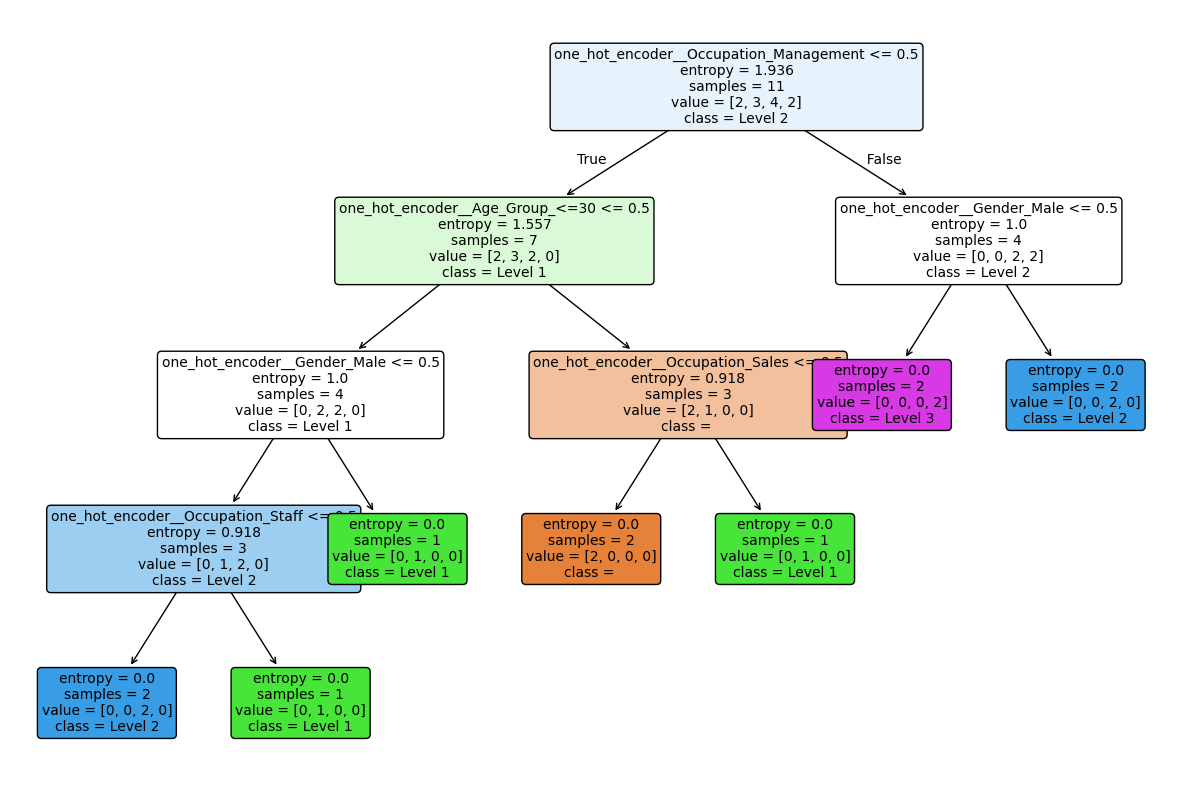

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create the dataset
data = pd.DataFrame({
    'Occupation': ['Service', 'Service', 'Service', 'Management', 'Management', 
                   'Management', 'Management', 'Sales', 'Sales', 'Staff', 'Staff'],
    'Gender': ['Female', 'Male', 'Male', 'Male', 'Female', 
               'Male', 'Female', 'Female', 'Male', 'Female', 'Male'],
    'Age': [45, 25, 33, 25, 35, 26, 45, 40, 30, 50, 25],
    'Salary': [48000, 25000, 35000, 45000, 65000, 45000, 70000, 50000, 40000, 40000, 25000]
})

# Discretize salary
def discretize_salary(salary):
    if salary < 35000:
        return 1
    elif salary < 45000:
        return 2
    elif salary < 55000:
        return 3
    else:
        return 4

# Discretize age
def discretize_age(age):
    if age <= 30:
        return "<=30"
    elif age <= 40:
        return "<=40"
    else:
        return "<=50"

# Apply discretization
data['Salary_Level'] = data['Salary'].apply(discretize_salary)
data['Age_Group'] = data['Age'].apply(discretize_age)

print("Original data with discretized values:")
print(data)

# Function to calculate impurity measure for a split
def calculate_impurity(data, split_col, split_value=None):
    if split_value is None:  # For categorical variables
        left = data[data[split_col] == split_value]
        right = data[data[split_col] != split_value]
    else:  # For categorical variables where we want to check equality
        left = data[data[split_col] == split_value]
        right = data[data[split_col] != split_value]
    
    total_samples = len(data)
    left_samples = len(left)
    right_samples = len(right)
    
    # Calculate proportions
    pl = left_samples / total_samples
    pr = right_samples / total_samples
    
    # Calculate class distributions in left and right nodes
    levels = sorted(data['Salary_Level'].unique())
    p_j_tl = {}
    p_j_tr = {}
    
    for level in levels:
        if left_samples > 0:
            p_j_tl[level] = len(left[left['Salary_Level'] == level]) / left_samples
        else:
            p_j_tl[level] = 0
            
        if right_samples > 0:
            p_j_tr[level] = len(right[right['Salary_Level'] == level]) / right_samples
        else:
            p_j_tr[level] = 0
    
    # Calculate sum of absolute differences
    sum_abs_diff = sum(abs(p_j_tl.get(level, 0) - p_j_tr.get(level, 0)) for level in levels)
    
    # Calculate Q(s|t)
    q_st = 2 * pl * pr
    
    # Calculate impurity measure Φ(s|t)
    phi_st = q_st * sum_abs_diff
    
    return {
        'split': f"{split_col}={split_value}",
        'PL': pl,
        'PR': pr,
        'class_distributions_left': p_j_tl,
        'class_distributions_right': p_j_tr,
        'sum_abs_diff': sum_abs_diff,
        'Q_st': q_st,
        'Phi_st': phi_st
    }

# Evaluate all possible splits
splits = []

# Age splits
for age_group in ['<=30', '<=40', '<=50']:
    splits.append(calculate_impurity(data, 'Age_Group', age_group))

# Occupation splits
for occupation in data['Occupation'].unique():
    splits.append(calculate_impurity(data, 'Occupation', occupation))

# Gender splits
for gender in data['Gender'].unique():
    splits.append(calculate_impurity(data, 'Gender', gender))

# Find the best split
best_split = max(splits, key=lambda x: x['Phi_st'])

print("\nAll splits evaluated:")
for split in splits:
    print(f"Split: {split['split']}, Φ(s|t): {split['Phi_st']:.3f}")

print("\nBest split:")
print(f"Split attribute: {best_split['split']}")
print(f"PL: {best_split['PL']:.3f}, PR: {best_split['PR']:.3f}")
print(f"Sum of absolute differences: {best_split['sum_abs_diff']:.3f}")
print(f"Q(s|t): {best_split['Q_st']:.3f}")
print(f"Φ(s|t): {best_split['Phi_st']:.3f}")
print("\nClass distributions in left node:")
for level, prob in best_split['class_distributions_left'].items():
    print(f"Level {level}: {prob:.3f}")
print("\nClass distributions in right node:")
for level, prob in best_split['class_distributions_right'].items():
    print(f"Level {level}: {prob:.3f}")

# Prepare features and target
X = data[['Occupation', 'Gender', 'Age_Group']]
y = data['Salary_Level']

# Convert categorical variables to numerical
# First encode occupation and gender
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['Occupation', 'Gender', 'Age_Group'])],
    remainder='passthrough'
)
X_encoded = ct.fit_transform(X)

# Get feature names after encoding
feature_names = ct.get_feature_names_out()

# Train a decision tree with max_depth=1 to get only one split
clf = tree.DecisionTreeClassifier(max_depth=5, criterion='entropy')
clf = clf.fit(X_encoded, y)

# Plot the tree
plt.figure(figsize=(15, 10))
tree.plot_tree(clf, feature_names=feature_names, class_names=['', 'Level 1', 'Level 2', 'Level 3', 'Level 4'], 
               filled=True, rounded=True, fontsize=10)

# Text representation of the tree
text_tree = tree.export_text(clf, feature_names=feature_names)
print("\nText representation of the decision tree:")
print(text_tree)

# Print feature importances to verify the best split
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nFeature ranking by importance:")
for i in range(len(feature_names)):
    if importances[indices[i]] > 0:
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

print("\n Manual Decision Tree Based on calculations -----")
# Extract the best split attribute and value
best_split_info = best_split['split'].split('=')
best_attr = best_split_info[0]
best_val = best_split_info[1]

print(f"Root node split: {best_attr} = {best_val}")
left_data = data[data[best_attr] == best_val]
right_data = data[data[best_attr] != best_val]

print(f"\nLeft node ({best_attr} = {best_val}):")
print(f"Number of samples: {len(left_data)}")
for level in sorted(left_data['Salary_Level'].unique()):
    count = len(left_data[left_data['Salary_Level'] == level])
    percentage = count / len(left_data) * 100
    print(f"  Salary Level {level}: {count} samples ({percentage:.1f}%)")

print(f"\nRight node ({best_attr} != {best_val}):")
print(f"Number of samples: {len(right_data)}")
for level in sorted(right_data['Salary_Level'].unique()):
    count = len(right_data[right_data['Salary_Level'] == level])
    percentage = count / len(right_data) * 100
    print(f"  Salary Level {level}: {count} samples ({percentage:.1f}%)")

print("\nSimple text visualization of the decision tree:")
print("                    Root")
print("                     |")
print(f"                 {best_attr}={best_val}?")
print("                   /   \\")
print("                  /     \\")
print("                Yes     No")
print("                /         \\")
left_dist = ", ".join([f"L{level}: {best_split['class_distributions_left'].get(level, 0):.3f}" for level in sorted(data['Salary_Level'].unique())])
right_dist = ", ".join([f"L{level}: {best_split['class_distributions_right'].get(level, 0):.3f}" for level in sorted(data['Salary_Level'].unique())])
print(f"    [{left_dist}]    [{right_dist}]")

4.2 Use the CART methodology to develop a classification model for the diagnosis.  

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv('breast-cancer-wisconsin.csv')
df.head

<bound method NDFrame.head of       Sample  F1  F2  F3  F4  F5  F6  F7  F8  F9  Class
0    1000025   5   1   1   1   2   1   3   1   1      2
1    1002945   5   4   4   5   7  10   3   2   1      2
2    1015425   3   1   1   1   2   2   3   1   1      2
3    1016277   6   8   8   1   3   4   3   7   1      2
4    1017023   4   1   1   3   2   1   3   1   1      2
..       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..    ...
694   776715   3   1   1   1   3   2   1   1   1      2
695   841769   2   1   1   1   2   1   1   1   1      2
696   888820   5  10  10   3   7   3   8  10   2      4
697   897471   4   8   6   4   3   4  10   6   1      4
698   897471   4   8   8   5   4   5  10   4   1      4

[699 rows x 11 columns]>

In [9]:
df.replace('?', pd.NA, inplace=True)

C:\Users\vidhi\AppData\Local\Temp\ipykernel_26684\3043903598.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.replace('?', pd.NA, inplace=True)


In [10]:
df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting errors='coerce' will turn non-numeric into NaN
df.fillna(df.median(), inplace=True)

In [11]:
df['Class'] = df['Class'].astype('category')

In [12]:
# Step 5: Split the data into features (X) and target (y)
X = df.drop(columns=['Sample', 'Class'])  # Drop 'Sample' column and 'Class' target column
y = df['Class']

In [13]:
# Step 6: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Step 7: Train a Decision Tree Classifier (CART) with entropy criterion
cart_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [15]:
# Step 8: Predict on the test set
y_pred = cart_model.predict(X_test)

In [16]:
# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9333


In [17]:
# Additional evaluation metrics:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[137   6]
 [  8  59]]


In [18]:
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           2       0.94      0.96      0.95       143
           4       0.91      0.88      0.89        67

    accuracy                           0.93       210
   macro avg       0.93      0.92      0.92       210
weighted avg       0.93      0.93      0.93       210

